In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

# 파일 데이터 가져와서 라벨 붙이기 

In [ ]:
# 경로확인 

In [3]:
pwd

'C:\\Users\\bitcamp\\Project4\\카테고리분류모델피클'

In [ ]:
# 데이터가 있는 경로로 이동

In [5]:
cd C:\Users\bitcamp\Project4\data\CNBC뉴스분류-20220425T095102Z-001\CNBC뉴스분류

C:\Users\bitcamp\Project4\data\CNBC뉴스분류-20220425T095102Z-001\CNBC뉴스분류


In [6]:
# 데이터 리스팅
import os
# csv파일 경로 리스팅 
data_lis = os.listdir('./')
data_lis

['labeled_news_oil_0_100_oil_price.csv.csv',
 'labeled_news_oil_100_200_oil_price.csv.csv',
 'labeled_news_oil_200_300_oil_price.csv.csv',
 'labeled_news_oil_300_400_oil_price.csv.csv',
 'labeled_news_oil_400_500_oil_price.csv.csv',
 'labeled_news_oil_500_600_oil_price.csv.csv',
 'labeled_news_oil_600_700_oil_price.csv.csv',
 'labeled_news_oil_700_end_oil_price.csv.csv',
 'labeled_news_semiconductor_0_100_semicondutor.csv.csv',
 'labeled_news_semiconductor_200_300_semicondutor.csv.csv',
 'labeled_news_semiconductor_300_400_semicondutor.csv.csv',
 'labeled_news_semiconductor_400_500_semicondutor.csv.csv',
 'labeled_news_semiconductor_500_600_semicondutor.csv.csv',
 'labeled_news_semiconductor_600_700_semicondutor.csv.csv',
 'labeled_news_semiconductor_700_end_semicondutor.csv.csv',
 'labeled_news_ship_0_100_ship_building.csv.csv',
 'labeled_news_ship_200_300_ship_building.csv.csv',
 'labeled_news_ship_300_400_ship_building.csv.csv',
 'labeled_news_ship_400_500_ship_building.csv.csv',
 '

In [7]:
# 반복문 이용해서 데이터 합치기 
# csv파일 여러개 읽어와서 합치기 
df_cnbc = pd.DataFrame()

for files in data_lis:
    # advertisement 빼고 합치기 
    df = pd.read_csv(files,index_col=0)
    df_cnbc = pd.concat([df_cnbc,df])    

In [ ]:
df = df_cnbc

In [9]:
df.head()

,date,content,label
0,2022-04-21T12:13:01+0000,"['As the oil market tightens, RBC Capital Mark...",3
1,2022-04-11T12:52:02+0000,['U.S. stock futures were slightly lower Monda...,100
2,2022-04-01T17:43:47+0000,['President Joe Biden on Thursday announced a ...,-1
3,2022-04-01T16:44:15+0000,['President Joe Biden’s top economic advisor s...,100
4,2022-03-31T04:48:37+0000,['Oil prices were lower on Thursday as the Whi...,-1


In [ ]:
# 모델이랑 피클 저장할 경로로 바꿔주기
# ./카테고리분류모델피클 

In [10]:
cd C:\Users\bitcamp\Project4\카테고리분류모델피클

C:\Users\bitcamp\Project4\카테고리분류모델피클


# 토크나이징 하기 

In [11]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re

In [12]:
def preprocessing(docs):
    tokenizer = RegexpTokenizer('[\w]+')
    stop_words = stopwords.words('english')
    p_stemmer = PorterStemmer()  # 어근 복원 : runs, running, ran => run,  cars => car
#     p = re.compile("[0-9]+")
#     숫자제거해야됨
#     docs = [p.sub(i) for i in docs]
    docs = BeautifulSoup(docs, "html5lib").get_text()
    low = docs.lower()
    tokens = tokenizer.tokenize(low)
    stopped_tokens = [i for i in tokens if not i in stop_words]
    stopped_tokens = [re.sub('[^a-zA-Z0-9]',' ',i) for i in stopped_tokens]
    stemmer_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    one_rmv = [w for w in stemmer_tokens if len(w)>1]
  
    return one_rmv

In [ ]:
# 함수 적용 
df['tokened'] = df['content'].apply(preprocessing)

# @@토큰화 하기전 컬럼 보존 @@

In [15]:
df = df.reset_index().drop('index',axis=1)

In [154]:
df['label'].unique()

array([  3, 100,  -1,  22,   1,  13, 102,  15,  12,  17, 104,  19, 103,
        28,  24,  31,  20, 101,  21,  29,  32], dtype=int64)

# 전처리 하기

In [17]:
# 전처리 할 변수 만들어 주기 
preprocessed_sentences = df['tokened']

In [19]:
preprocessed_sentences

0       [oil, market, tighten, rbc, capit, market, thi...
1       [stock, futur, slightli, lower, monday, morn, ...
2       [presid, joe, biden, thursday, announc, histor...
3       [presid, joe, biden, top, econom, advisor, sug...
4       [oil, price, lower, thursday, white, hous, ann...
                              ...                        
3013    [slew, electr, vehicl, compani, oper, china, f...
3014    [world, govern, pledg, 710, billion, sustain, ...
3015    [use, car, price, appear, stuck, high, gear, d...
3016    [investor, ron, baron, one, tesla, largest, sh...
3017    [alreadi, invest, retir, money, kid, colleg, s...
Name: tokened, Length: 3018, dtype: object

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()

# fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성.
tokenizer.fit_on_texts(preprocessed_sentences) 

In [21]:
print(tokenizer.word_index)

{'said': 1, 'year': 2, 'compani': 3, 'oil': 4, 'price': 5, 'market': 6, 'new': 7, 'product': 8, 'vehicl': 9, 'also': 10, 'china': 11, 'would': 12, 'trade': 13, 'could': 14, 'percent': 15, 'expect': 16, 'like': 17, 'report': 18, 'last': 19, 'one': 20, 'industri': 21, 'million': 22, 'go': 23, 'time': 24, 'week': 25, 'trump': 26, 'stock': 27, 'billion': 28, 'day': 29, 'cnbc': 30, 'energi': 31, 'state': 32, 'global': 33, 'accord': 34, 'suppli': 35, 'month': 36, 'make': 37, 'includ': 38, 'first': 39, 'share': 40, 'manufactur': 41, 'countri': 42, 'demand': 43, 'busi': 44, 'presid': 45, 'electr': 46, 'say': 47, 'come': 48, 'use': 49, 'world': 50, '000': 51, 'barrel': 52, 'plan': 53, 'analyst': 54, 'car': 55, 'peopl': 56, 'get': 57, 'per': 58, 'quarter': 59, 'high': 60, 'think': 61, 'two': 62, 'increas': 63, 'see': 64, 'sinc': 65, 'produc': 66, 'invest': 67, 'ad': 68, 'told': 69, 'sale': 70, 'work': 71, 'take': 72, 'cost': 73, 'technolog': 74, 'close': 75, 'may': 76, 'even': 77, 'start': 78, '

In [22]:
print(tokenizer.word_counts)

OrderedDict([('oil', 7210), ('market', 6320), ('tighten', 177), ('rbc', 134), ('capit', 999), ('think', 2287), ('exxon', 151), ('mobil', 411), ('well', 1911), ('posit', 1123), ('benefit', 552), ('share', 2828), ('chevron', 153), ('look', 1790), ('expens', 426), ('stock', 3361), ('futur', 1839), ('slightli', 282), ('lower', 1453), ('monday', 1709), ('morn', 430), ('wall', 756), ('street', 963), ('bounc', 128), ('back', 2044), ('lose', 329), ('week', 3486), ('dow', 538), ('impli', 66), ('open', 892), ('declin', 1243), ('roughli', 473), ('160', 33), ('point', 1758), ('500', 963), ('nasdaq', 436), ('also', 4980), ('red', 134), ('cnbc', 3337), ('10', 1984), ('year', 9537), ('treasuri', 352), ('yield', 487), ('top', 1149), ('76', 125), ('start', 2055), ('tech', 971), ('focus', 469), ('composit', 324), ('saw', 436), ('biggest', 804), ('last', 3745), ('fall', 911), ('nearli', 962), ('investor', 1911), ('prepar', 319), ('aggress', 276), ('polici', 1080), ('feder', 759), ('reserv', 591), ('slid'

In [23]:
len(tokenizer.word_counts)

25898

In [24]:
count =  pd.Series(tokenizer.word_counts.values())
np.mean(count) 
max(count)
#여기중에서 빈도수 몇까지 볼거냐 .. 

17285

(array([2.5123e+04, 4.0400e+02, 1.5300e+02, 6.4000e+01, 3.8000e+01,
        4.0000e+01, 2.2000e+01, 1.3000e+01, 9.0000e+00, 7.0000e+00,
        7.0000e+00, 4.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.000000e+00, 3.466800e+02, 6.923600e+02, 1.038040e+03,
        1.383720e+03, 1.729400e+03, 2.075080e+03, 2.420760e+03,
        2.766440e+03, 3.112120e+03, 3.457800e+03, 3.803480e+03,
        4.149160e+03, 4.494840e+03, 4.840520e+03, 5.186200e+03,
        5.531880e+03, 5.877560e+03, 6.223240e+03, 6.568920e+03

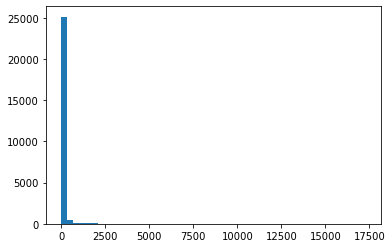

In [25]:
plt.hist(count,bins=50)

In [26]:
vocab_size = 10000
tokenizer = Tokenizer(num_words = vocab_size + 1) 
tokenizer.fit_on_texts(preprocessed_sentences)

In [27]:
#fit_on_texts로 토큰화 한 것을 pickle로 저장 
import pickle
import re

In [28]:
# pickle파일이 현재 디렉토리에 저장됨 
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

In [29]:
# 단어를 시퀀스 형태로 변환해주기 
x = tokenizer.texts_to_sequences(preprocessed_sentences)

In [143]:
# y라벨 벡터화 
topics = [[0],[26],[6,9,10,23,25,27],[16,30],[2,4,5,7,8,11,14,18]] # oil, ship, sc, steel, vh
def classifi(label):
    for key, topic in enumerate(topics):
        if label in topic:
            return key+100
    return label

In [144]:
label = set()
for i in range(-1,33):
    label.add(classifi(i))
len(list(label))

21

In [59]:
def labeling(y):
    a.index(y)
    tmp = [0 for _ in range(len(a))]    
    tmp[a.index(y)] = 1    
    return tmp 

In [65]:
df['vectorized_label'] = df['label'].apply(labeling)

In [136]:
# 훈련시킬 할 라벨 지정 
y = np.array(df['vectorized_label'].to_list())

In [130]:
y

0       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
3013    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3014    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3015    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3016    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3017    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: vectorized_label, Length: 3018, dtype: object

In [135]:
df.astype({'label':'float32'})

,date,content,label,tokened,vectorized_label
0,2022-04-21T12:13:01+0000,"['As the oil market tightens, RBC Capital Mark...",3.0,"[oil, market, tighten, rbc, capit, market, thi...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2022-04-11T12:52:02+0000,['U.S. stock futures were slightly lower Monda...,100.0,"[stock, futur, slightli, lower, monday, morn, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2022-04-01T17:43:47+0000,['President Joe Biden on Thursday announced a ...,-1.0,"[presid, joe, biden, thursday, announc, histor...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2022-04-01T16:44:15+0000,['President Joe Biden’s top economic advisor s...,100.0,"[presid, joe, biden, top, econom, advisor, sug...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2022-03-31T04:48:37+0000,['Oil prices were lower on Thursday as the Whi...,-1.0,"[oil, price, lower, thursday, white, hous, ann...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
3013,2022-03-25T03:35:06+0000,['A slew of electric vehicle companies operati...,104.0,"[slew, electr, vehicl, compani, oper, china, f...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3014,2022-04-14T15:49:04+0000,['The world’s governments have pledged more th...,-1.0,"[world, govern, pledg, 710, billion, sustain, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3015,2022-04-07T12:54:48+0000,['Used-car prices appear to be stuck in high g...,104.0,"[use, car, price, appear, stuck, high, gear, d...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3016,2022-04-07T13:17:07+0000,['Investor Ron Baron has been one of Tesla’s l...,104.0,"[investor, ron, baron, one, tesla, largest, sh...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# 모델 돌리기 

In [137]:
# 훈련시킬 데이터 셋 나누기
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=111)

In [138]:
# 기사최대길이로 패딩해주기 
max_len = max([len(l) for l in df['tokened']])

x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test,maxlen=max_len)

y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

In [139]:
# LSTM 모델 구성

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

embedding_dim = 128
hidden_units = 128
num_classes = 21

with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(LSTM(hidden_units))
    model.add(Dense(num_classes, activation='softmax'))

In [146]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# 에포크20때까지 val_acc가 개선되지않으면 스톱 
mc = ModelCheckpoint('best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 제일 훈련이 잘된것을 현재경로에 저장 


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(x_train, y_train, batch_size=64, epochs=30, callbacks=[es, mc], validation_data=(x_test, y_test) )

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.0160 - acc: 0.9917
Epoch 00001: val_acc improved from -inf to 0.45364, saving model to best_model2.h5
38/38 [==============================] - 17s 413ms/step - loss: 0.0160 - acc: 0.9917 - val_loss: 3.4974 - val_acc: 0.4536
Epoch 2/30
38/38 [==============================] - ETA: 0s - loss: 0.0123 - acc: 0.9925
Epoch 00002: val_acc improved from 0.45364 to 0.45695, saving model to best_model2.h5
38/38 [==============================] - 15s 402ms/step - loss: 0.0123 - acc: 0.9925 - val_loss: 3.5423 - val_acc: 0.4570
Epoch 3/30
38/38 [==============================] - ETA: 0s - loss: 0.0112 - acc: 0.9921
Epoch 00003: val_acc improved from 0.45695 to 0.45861, saving model to best_model2.h5
38/38 [==============================] - 15s 404ms/step - loss: 0.0112 - acc: 0.9921 - val_loss: 3.6599 - val_acc: 0.4586
Epoch 4/30
38/38 [==============================] - ETA: 0s - loss: 0.0123 - acc: 0.9921
Epoch 00004: val_acc im

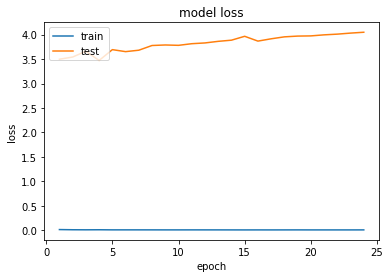

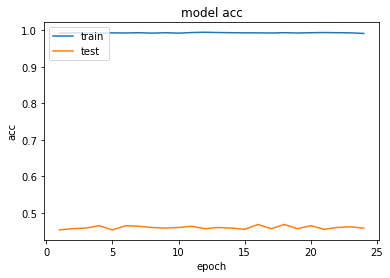

In [147]:
# 모델 시각화 
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()